<a href="https://colab.research.google.com/github/rakesh4real/ocr.pytorch/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
!git clone https://github.com/rakesh4real/ocr.pytorch.git

Cloning into 'ocr.pytorch'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 313 (delta 4), reused 9 (delta 1), pack-reused 293
Receiving objects: 100% (313/313), 105.79 MiB | 28.20 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [75]:
%cd ocr.pytorch/checkpoints
!curl -O https://raw.githubusercontent.com/rakesh4real/ocr.pytorch/master/checkpoints/CTPN.pth
!curl -O https://raw.githubusercontent.com/rakesh4real/ocr.pytorch/master/checkpoints/CRNN-1010.pth
%cd .. 

/content/ocr.pytorch/ocr.pytorch/checkpoints
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.6M  100 67.6M    0     0  35.0M      0  0:00:01  0:00:01 --:--:-- 35.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.1M  100 43.1M    0     0  30.0M      0  0:00:01  0:00:01 --:--:-- 30.0M
/content/ocr.pytorch/ocr.pytorch


# Test Preds

In [76]:
!python test_one.py test_images/t9.jpg

{0: [array([228.88672738,  59.14388929, 425.        ,  58.3706646 ,
       229.        ,  84.9433912 , 425.11327262,  84.17016651,
         0.95567369]), 'CASHRECBIPT'], 1: [array([180.95191589,  96.46872378, 489.        ,  95.80917096,
       181.        , 117.46861368, 489.04808411, 116.80906086,
         0.9192903 ]), 'Adress: 1234Lorem Ipsum,Dolor'], 2: [array([181.        , 118.22272551, 361.05795408, 118.67743565,
       180.94204592, 138.62256049, 361.        , 139.07727063,
         0.78397667]), 'Tel:123-456-7890'], 3: [array([405.        , 156.41666126, 473.        , 156.41666126,
       405.        , 178.24999523, 473.        , 178.24999523,
         0.82759088]), '10:35'], 4: [array([181.        , 158.26805636, 345.01114004, 158.34306217,
       180.98885996, 179.65693987, 345.        , 179.73194568,
         0.89424855]), 'Date: 01-01-2018'], 5: [array([437.        , 202.75      , 490.46303502, 204.84143969,
       435.53696498, 226.15856031, 489.        , 228.25      ,
  

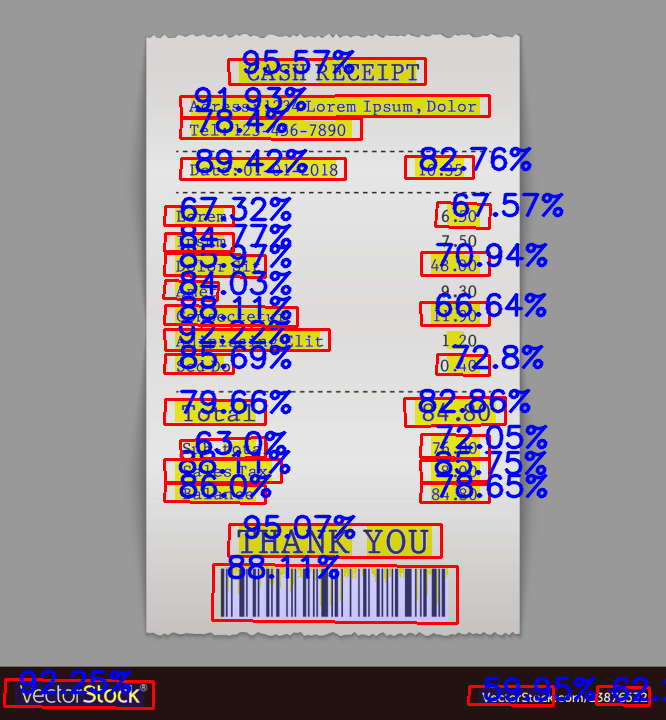

In [10]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('result.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

# Test Detections

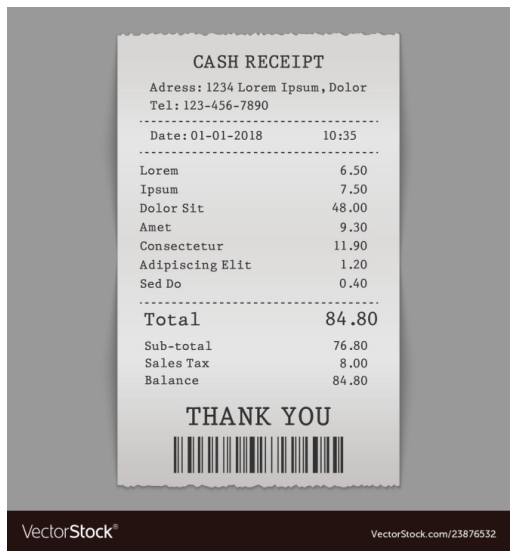

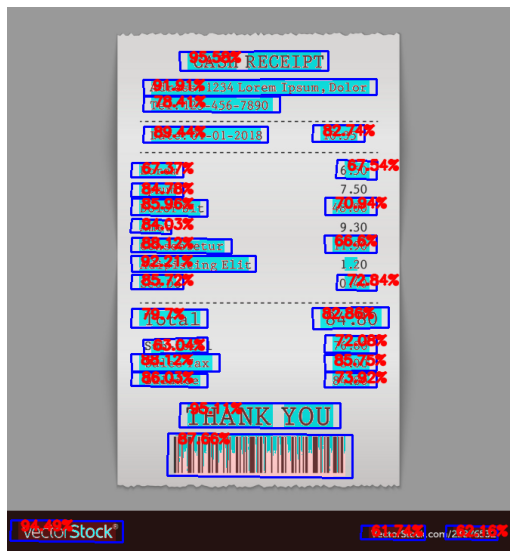

In [105]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from detect.ctpn_model import CTPN_Model
from detect.ctpn_utils import gen_anchor, bbox_transfor_inv, clip_box, filter_bbox,nms, TextProposalConnectorOriented
from detect.ctpn_utils import resize
from detect import config

prob_thresh = 0.5
height = 720
gpu = True
if not torch.cuda.is_available():
    gpu = False
device = torch.device('cuda:0' if gpu else 'cpu')
weights = os.path.join(config.checkpoints_dir, 'CTPN.pth')
model = CTPN_Model()
model.load_state_dict(torch.load(weights, map_location=device)['model_state_dict'])
model.to(device)
model.eval()


def dis(image):
    cv2.imshow('image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def disp(image):
  plt.figure(figsize=(10,10))
  plt.imshow(image)
  plt.axis('off')
  plt.show()

def disp_img_at(path):
  disp(cv2.imread(path))

def get_det_boxes(image, display = True, expand = True):
    image = resize(image, height=height)
    image_r = image.copy()
    image_c = image.copy()
    h, w = image.shape[:2]
    image = image.astype(np.float32) - config.IMAGE_MEAN
    image = torch.from_numpy(image.transpose(2, 0, 1)).unsqueeze(0).float()

    with torch.no_grad():
        image = image.to(device)
        cls, regr = model(image)
        cls_prob = F.softmax(cls, dim=-1).cpu().numpy()
        regr = regr.cpu().numpy()
        anchor = gen_anchor((int(h / 16), int(w / 16)), 16)
        bbox = bbox_transfor_inv(anchor, regr)
        bbox = clip_box(bbox, [h, w])
        # print(bbox.shape)

        fg = np.where(cls_prob[0, :, 1] > prob_thresh)[0]
        # print(np.max(cls_prob[0, :, 1]))
        select_anchor = bbox[fg, :]
        select_score = cls_prob[0, fg, 1]
        select_anchor = select_anchor.astype(np.int32)
        # print(select_anchor.shape)
        keep_index = filter_bbox(select_anchor, 16)

        # nms
        select_anchor = select_anchor[keep_index]
        select_score = select_score[keep_index]
        select_score = np.reshape(select_score, (select_score.shape[0], 1))
        nmsbox = np.hstack((select_anchor, select_score))
        keep = nms(nmsbox, 0.3)
        # print(keep)
        select_anchor = select_anchor[keep]
        select_score = select_score[keep]

        # text line-
        textConn = TextProposalConnectorOriented()
        text = textConn.get_text_lines(select_anchor, select_score, [h, w])

        # expand text
        if expand:
            for idx in range(len(text)):
                text[idx][0] = max(text[idx][0] - 10, 0)
                text[idx][2] = min(text[idx][2] + 10, w - 1)
                text[idx][4] = max(text[idx][4] - 10, 0)
                text[idx][6] = min(text[idx][6] + 10, w - 1)

        # print(text)
        if display:
            blank = np.zeros(image_c.shape,dtype=np.uint8)
            for box in select_anchor:
                pt1 = (box[0], box[1])
                pt2 = (box[2], box[3])
                blank = cv2.rectangle(blank, pt1, pt2, (50, 0, 0), -1)
            image_c = image_c+blank
            image_c[image_c>255] = 255
            for detid, i in enumerate(text):
                s = str(round(i[-1] * 100, 2)) + '%'
                i = [int(j) for j in i]
                # (0,1)+ ---------------+ (2,3)
                #      |      text      |
                # (4,5)+ ---------------+ (6,7)
                
                x1, y1 = i[0], i[1] # top-left
                x2, y2 = i[6], i[7] # bottom-right
                crop = image_c[y1:y2, x1:x2, :] 
                plt.close();
                # plt.imshow(crop);
                # plt.axis('off')
                # plt.show();
                # cv2.imwrite(f'cropped/{detid}.png', crop)

                cv2.line(image_c, (i[0], i[1]), (i[2], i[3]), (0, 0, 255), 2)
                cv2.line(image_c, (i[0], i[1]), (i[4], i[5]), (0, 0, 255), 2)
                cv2.line(image_c, (i[6], i[7]), (i[2], i[3]), (0, 0, 255), 2)
                cv2.line(image_c, (i[4], i[5]), (i[6], i[7]), (0, 0, 255), 2)
                cv2.putText(image_c, s, (i[0]+13, i[1]+13),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.6,
                            (255,0,0),
                            2,
                            cv2.LINE_AA)
            # dis(image_c)
        # print(text)
        return text,image_c,image_r

if __name__ == '__main__':
    img_path = '/content/ocr.pytorch/test_images/t9.jpg'
    image = cv2.imread(img_path)
    print
    text,image_c, image_r = get_det_boxes(image)
    # predictions
    # print("="*100+"\n", text, "\n"+"="*100)
    disp(image_r) # original
    disp(image_c) # detected

# Test Predictions

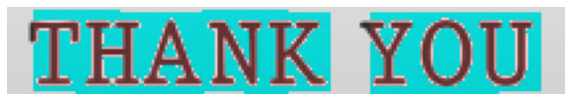

工HANKYOU


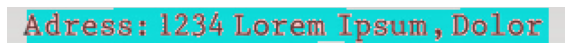

Adress:l234Lorem Ipsum,Dolor


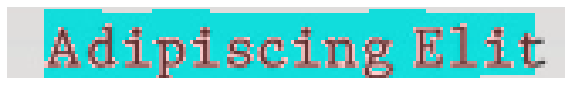

Adipiscing Blit


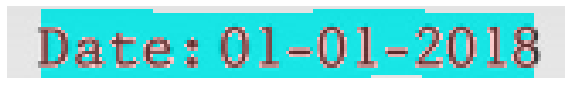

Date:01-01-2018


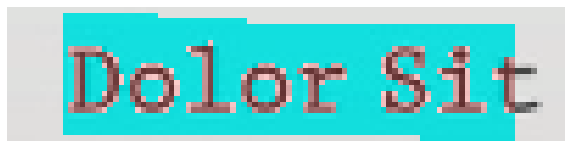

Dolor Sit


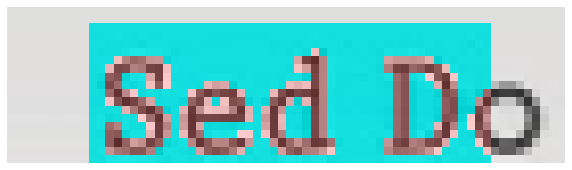

SeaDo


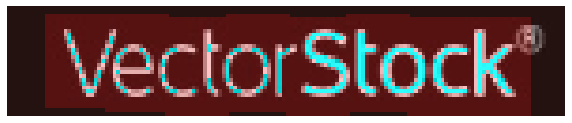

ectorStock


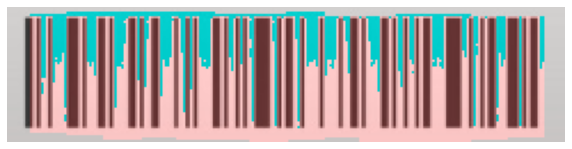

Ⅲ删删ⅢⅢ


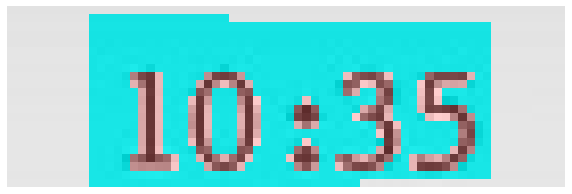

10:35


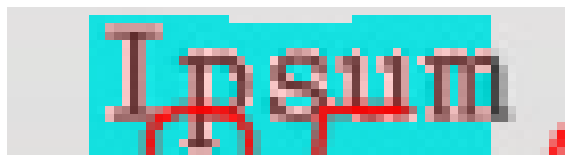

TPsumm


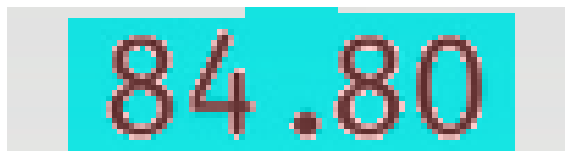

84.80


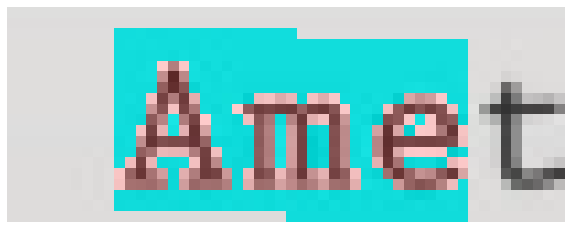

Amet


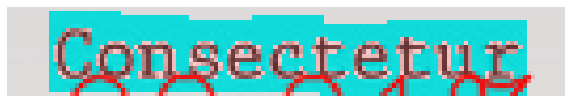

CopsectetE


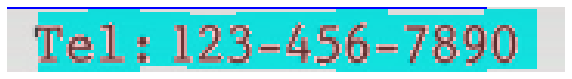

Tel:123-456-7890


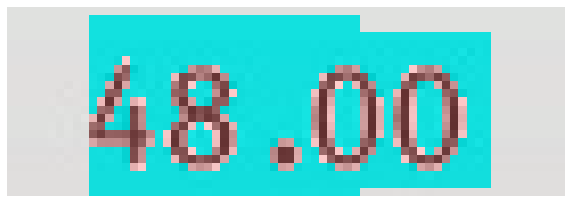

48.00


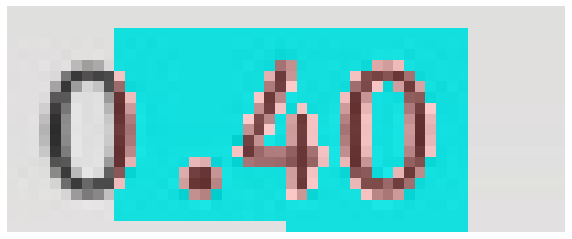

0.40


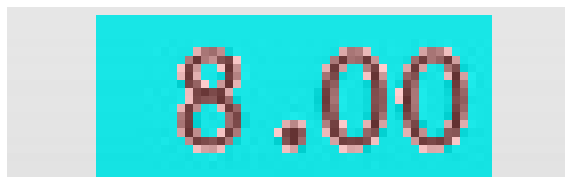

8.00


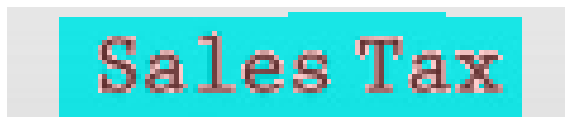

Sales Tax


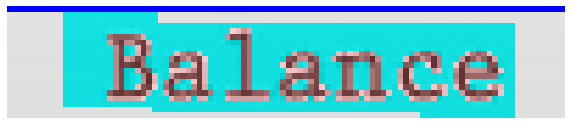

BaLance


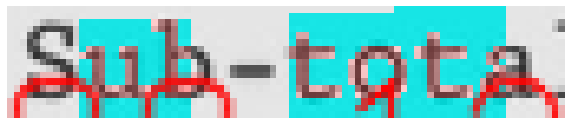

SuA-totA


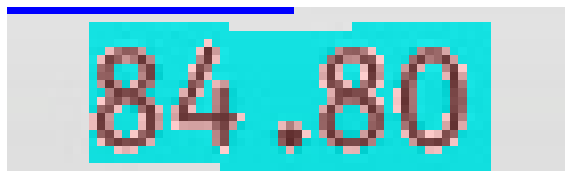

84.80


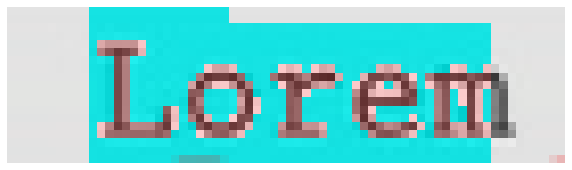

Lorem


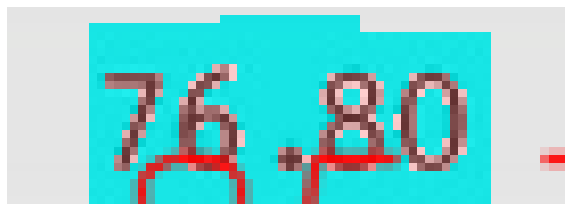

在,80


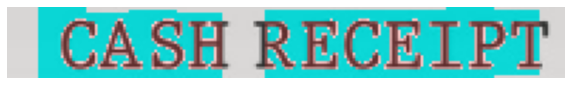

CASHRECBIPT


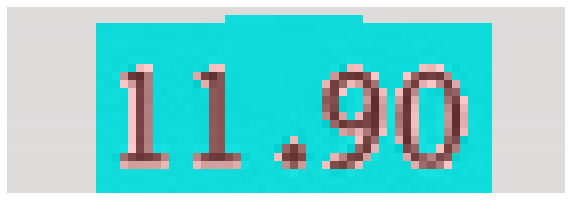

11.90


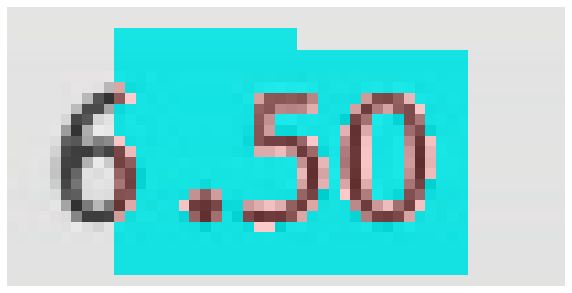

6.50


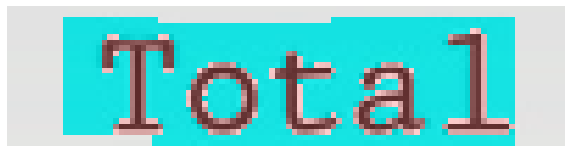

Tota1


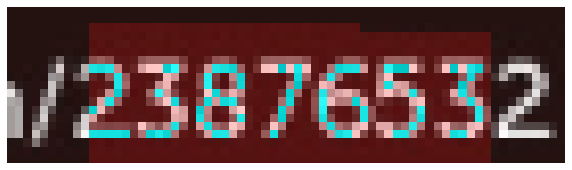

23876532


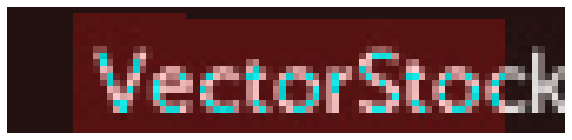

vectorStocl


In [104]:
import torch.nn as nn
# import torchvision.models as models
import torch, os
from PIL import Image
import cv2
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import random
from recognize.crnn import CRNN
from recognize import config

# copy from mydataset
class resizeNormalize(object):
    def __init__(self, size, interpolation=Image.LANCZOS, is_test=True):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()
        self.is_test = is_test

    def __call__(self, img):
        w, h = self.size
        w0 = img.size[0]
        h0 = img.size[1]
        if w <= (w0 / h0 * h):
            img = img.resize(self.size, self.interpolation)
            img = self.toTensor(img)
            img.sub_(0.5).div_(0.5)
        else:
            w_real = int(w0 / h0 * h)
            img = img.resize((w_real, h), self.interpolation)
            img = self.toTensor(img)
            img.sub_(0.5).div_(0.5)
            tmp = torch.zeros([img.shape[0], h, w])
            start = random.randint(0, w - w_real - 1)
            if self.is_test:
                start = 0
            tmp[:, :, start:start + w_real] = img
            img = tmp
        return img

# copy from utils
class strLabelConverter(object):
    def __init__(self, alphabet, ignore_case=False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '_'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    # print(self.dict)
    def encode(self, text):
        length = []
        result = []
        for item in text:
            item = item.decode('utf-8', 'strict')
            length.append(len(item))
            for char in item:
                if char not in self.dict.keys():
                    index = 0
                else:
                    index = self.dict[char]
                result.append(index)
        text = result
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(),
                                                                                                         length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(
                t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

# recognize api
class PytorchOcr():
    def __init__(self, model_path='checkpoints/CRNN-1010.pth'):
        alphabet_unicode = config.alphabet_v2
        self.alphabet = ''.join([chr(uni) for uni in alphabet_unicode])
        # print(len(self.alphabet))
        self.nclass = len(self.alphabet) + 1
        self.model = CRNN(config.imgH, 1, self.nclass, 256)
        self.cuda = False
        if torch.cuda.is_available():
            self.cuda = True
            self.model.cuda()
            self.model.load_state_dict({k.replace('module.', ''): v for k, v in torch.load(model_path).items()})
        else:
            # self.model = nn.DataParallel(self.model)
            self.model.load_state_dict(torch.load(model_path, map_location='cpu'))
        self.model.eval()
        self.converter = strLabelConverter(self.alphabet)

    def recognize(self, img):
        h,w = img.shape[:2]
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        image = Image.fromarray(img)
        transformer = resizeNormalize((int(w/h*32), 32))
        image = transformer(image)
        image = image.view(1, *image.size())
        image = Variable(image)

        if self.cuda:
            image = image.cuda()

        preds = self.model(image)

        _, preds = preds.max(2)
        preds = preds.transpose(1, 0).contiguous().view(-1)

        preds_size = Variable(torch.IntTensor([preds.size(0)]))
        txt = self.converter.decode(preds.data, preds_size.data, raw=False).strip()

        return txt


if __name__ == '__main__':
    for i in range(29):
      recognizer = PytorchOcr()
      img_path = f'cropped/{i}.png'
      img = cv2.imread(img_path)
      h, w = img.shape[:2]
      res = recognizer.recognize(img)
    
      disp(img)
      print(res)
